# BAN 612-02 Zillow Project

## Group 4 - Aman Solanki, Krishna Jaideep Patel, Farzad Emami, Deepak Dileepkumar

The python ipynb file used to collect and prepare data

### Data Collection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import datetime
import random
import matplotlib.pylab as plt

#data collection
from bs4 import BeautifulSoup
import requests
import re

#merging data
import os
import glob

#imputing missing values
from sklearn.impute import KNNImputer

pd.set_option('display.max_columns',4000)
pd.set_option('display.max_rows',4000)

In [2]:
city_list = ['San Jose', 'San Francisco', 'Oakland',
             'Fremont', 'Santa Rosa', 'Hayward',
             'Sunnyvale', 'Concord', 'Santa Clara',
             'Vallejo', 'Berkeley', 'Fairfield', 'Richmond',
             'Antioch', 'Daly City', 'San Mateo', 'Vacaville',
             'San Leandro', 'Livermore', 'Napa', 'Redwood City',
             'Mountain View','Alameda', 'San Ramon', 'Pleasanton',
             'Union City', 'Milpitas', 'Palo Alto', 'Walnut Creek',
             'South San Francisco', 'Pittsburg', 'Cupertino', 'Petaluma',
             'San Rafael', 'Novato', 'Brentwood', 'Gilroy', 'Dublin',
             'Danville', 'San Bruno', 'Rohnert Park', 'Campbell',
             'Morgan Hill', 'Pacifica', 'Martinez', 'Oakley', 'Pleasant Hill', 'Menlo Park']

batch1 = ['San Jose', 'San Francisco', 'Oakland',
             'Fremont', 'Santa Rosa', 'Hayward',
             'Sunnyvale', 'Concord', 'Santa Clara',
             'Vallejo']

batch2 = ['Berkeley', 'Fairfield', 'Richmond',
             'Antioch', 'Daly City', 'San Mateo', 'Vacaville',
             'San Leandro', 'Livermore', 'Napa']

batch3 = ['Redwood City', 'Mountain View', 'Alameda', 'San Ramon', 'Pleasanton',
             'Union City', 'Milpitas', 'Palo Alto', 'South San Francisco']

batch4 = ['Pittsburg', 'Cupertino', 'Petaluma', 'San Rafael', 'Novato', 'Walnut Creek']

batch5 = ['Brentwood', 'Gilroy', 'Dublin', 'Danville','Foster City']

batch6 = ['San Bruno', 'Rohnert Park', 'Campbell','Half Moon Bay','Morgan Hill'] 

batch7 = ['Pacifica', 'Martinez', 'Oakley', 'Pleasant Hill', 'Menlo Park']

test = ['Hayward']

common_url = 'https://www.zillow.com/homes/for_sale/'

url_list = []
for city in test:
    #url_list.append(common_url+city+"/ca") #for page 1
    url_list.append(common_url+city+"/ca/2_p/") #for page 2

In [3]:
req_headers = {
    'casca'
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 axazs'
}

s = requests.Session()
link=[] #list to store listing url
listingAgent=[] #list to store the listing company of the property
temp=[] #temperory list to append all the collected data

for url in url_list:
    r = s.get(url, headers=req_headers)
    soup = BeautifulSoup(r.content, 'html.parser')
    for i in soup.findAll(class_="list-card-link list-card-link-top-margin list-card-img"):
        link.append(i.get('href')) #appends urls to link list
    for i in soup:
        listingCompany = soup.find_all('div', attrs={'class': 'list-card-truncate'})
        for i in listingCompany:
            company = i.text
            temp.append(company)
            temp = temp[:len(link)] #appends listing companies for only the accounted links

listingAgent.extend(temp) #adds all the temp elements to listingAgent list

In [4]:
print(len(link), 'links generated.')

40 links generated.


In [5]:
chunks = [link[x:x+8] for x in range(0, len(link), 8)] #creates 5 lists with 8 links in each list

In [6]:
len(chunks)

5

In [7]:
null_val = 'Not_Found' 
start_time = datetime.datetime.now()

print(start_time)

zillowDataList = [] #list to store dictionary generated for each property data.

s = requests.Session()

for i in range(len(chunks)):
    print('\n')
    print('Sleeping Now')
    print('------------------------------------------')
    print('\n')
    time.sleep(random.randint(26,30)) #sleeps after scraping 5 links
    for j in chunks[i]:
        zillowData = {}
        print('Sleeping Again....')
        time.sleep(random.randint(13,16)) #sleeps before scraping data from each link
        r = s.get(j, headers=req_headers)
        bs_html_data = BeautifulSoup(r.content, 'html.parser')

        print('Link: ', j)
        
        #price
        if bs_html_data.find('span', attrs={'class': 'ds-value'})!= None:
            price = re.sub("\D", "", bs_html_data.find('span', attrs={'class': 'ds-value'}).text) 
            zillowData['Price'] = price #adds price to dictionary 
        else:
            price = null_val
            zillowData['Price'] = price #adds null_val if price not found
        
        #address
        address_tags = bs_html_data.find_all('h1', attrs={'class': 'ds-address-container'})
            
        if address_tags != None:
            address_tags = bs_html_data.find_all('h1', attrs={'class': 'ds-address-container'})
            spans = address_tags[0].find_all('span')
                
        if spans != None:
            home_address = ' '.join([_.text for _ in spans])

            clean_home_address = re.sub(r'[^a-zA-Z0-9,_ ]', '', home_address)
            zillowData['Address'] = clean_home_address #full property address

            addr_line1 = clean_home_address.split(',')[0].strip() #address line 1

            home_city = clean_home_address.split(',')[-2].strip() #city
            zillowData['City'] = home_city #adds city to dictionary

            zipCode = int(clean_home_address.split(',')[-1].strip().split(' ')[-1].strip()) #zipcode
            zillowData['ZipCode'] = zipCode #adds zipcode to dictionary

            state = clean_home_address.split(',')[-1].strip().split(' ')[0].strip() #state
            zillowData['State'] = state #adds state to dictionary

        #zestimate
        zestimate = bs_html_data.find("p", attrs = {"class":"Text-aiai24-0 sc-fzoxKX sc-oTpqt loFLRQ"})
        value=(re.sub("\D", "", zestimate.text) if zestimate != None else null_val)
        zillowData['Zestimate'] = value #adds zestimate to dictionary

        
        #Interior details
        interior_details = bs_html_data.find_all('span', attrs={'class': 'Text-aiai24-0 cZksOw'}) #get interior details

        if interior_details != None:
            bedrooms = (interior_details[0].text.split(' ')[1] if interior_details[0] != None else null_val)
            zillowData['Bedrooms'] = bedrooms #adds bedrooms to dictionary
        
        #adds the specified data to the dictionary, if data is not found, null_val is added instead
        for i in interior_details:
            text = i.text
            if text.startswith('Total interior livable area:'):
                area = text.split()[4] if text.split()[4] != None else null_val
                zillowData['Living-Area'] = area  
            if text.startswith('Bathrooms:'):
                tBathrooms = text.split(':')[1] if text.split(':')[1] != None else null_val
                zillowData['Total-Bathrooms'] = (int(tBathrooms))
            if text.startswith('Full bathrooms:'):
                fBathrooms = text.split(':')[1] if text.split(':')[1] != None else null_val
                zillowData['Full-Bathrooms'] = fBathrooms
            if text.startswith('1/2 bathrooms:'):
                hBathrooms = text.split(':')[1] if text.split(':')[1] != None else null_val
                zillowData['Half-Bathrooms'] = hBathrooms
            if text.startswith('Fireplace:'):
                fireplace = text.split(':')[1] if text.split(':')[1] != None else null_val
                zillowData['Fireplace'] = fireplace
            if text.startswith('Lot size:'):
                lotSize = text.split()[2] if text.split()[2] != None else null_val
                zillowData['Lot-Size'] = lotSize
            if text.startswith('Home type:'):
                homeType = text.split(':')[1] if text.split(':')[1] != None else null_val
                zillowData['Home-Type'] = homeType 
            if text.startswith('New construction:'):
                newConstruction = text.split(':')[1] if text.split(':')[1] != None else null_val
                zillowData['New-Contruction'] = newConstruction
            if text.startswith('Year built:'):
                yearBuilt = text.split(':')[1] if text.split(':')[1] != None else null_val
                zillowData['Year-Built'] = yearBuilt
            if text.startswith('Utilities for property:'):
                utilitiesProvider = text.split(':')[1] if text.split(':')[1] != None else null_val
                zillowData['Utilities'] = utilitiesProvider
            if text.startswith('Sunscore: Great solar potentialSun Number™:'):
                sunScore = text.split(':')[2] if text.split(':')[2] != None else null_val
                zillowData['Sunscore'] = sunScore
            if text.startswith('HOA fee: $'):
                listingHOA = text.split(':')[1] if text.split(':')[1] != None else null_val
                zillowData['HOA'] = listingHOA
            if text.startswith('Tax assessed value:'):
                taxValue = text.split(':')[1] if text.split(':')[1] != None else null_val
                zillowData['Tax-Value'] = taxValue
            if text.startswith('Annual tax amount:'):
                aTax = text.split(':')[1] if text.split(':')[1] != None else null_val
                zillowData['Annual-Tax'] = aTax
            if text.startswith('Garage spaces:'):
                gSpace = text.split(':')[1] if text.split(':')[1] != None else null_val
                zillowData['Garage-Spaces'] = gSpace  
            if text.startswith('Stories:'):
                hStories = text.split(':')[1] if text.split(':')[1] != None else null_val
                zillowData['Stories'] = hStories
        
        zillowDataList.append(zillowData) #appends the dictionary to the list



print('Total time:',datetime.datetime.now()-start_time, 'minutes') 

2020-10-06 13:07:27.627285


Sleeping Now
------------------------------------------


Sleeping Again....
Link:  https://www.zillow.com/homedetails/1469-Salamanca-Ave-129-Hayward-CA-94544/2077773943_zpid/
Sleeping Again....
Link:  https://www.zillow.com/community/parkside-heights/318985697_zpid/
Sleeping Again....
Link:  https://www.zillow.com/homedetails/1524-Ortega-Ave-Hayward-CA-94544/68031406_zpid/
Sleeping Again....
Link:  https://www.zillow.com/homedetails/24834-Saint-Luke-Ct-Hayward-CA-94541/24968850_zpid/
Sleeping Again....
Link:  https://www.zillow.com/homedetails/25231-Whitman-St-APT-101-Hayward-CA-94544/82837919_zpid/
Sleeping Again....
Link:  https://www.zillow.com/homedetails/21062-Gary-Dr-APT-203-Hayward-CA-94546/24964614_zpid/
Sleeping Again....
Link:  https://www.zillow.com/homedetails/2409-Bridwell-Way-Hayward-CA-94545/82844902_zpid/
Sleeping Again....
Link:  https://www.zillow.com/homedetails/3318-Costa-Dr-Hayward-CA-94541/24967392_zpid/


Sleeping Now
---------------

In [8]:
zillow = pd.DataFrame(zillowDataList, index= range(len(zillowDataList))) #creates a dataFrame the list of dictionaries
zillow['Link'] = link #adds link column to the data frame
zillow['Listing-Company'] = listingAgent #adds listingCompany column to the data frame

In [9]:
zillow = zillow[['Address', 'City', 'ZipCode', 'State', 'Bedrooms','Price',
                  'Listing-Company', 'HOA', 'Zestimate', 'Link',
                  'Living-Area','Total-Bathrooms', 'Full-Bathrooms',
                  'Half-Bathrooms', 'Garage-Spaces','Stories', 'Fireplace',
                  'Lot-Size', 'Home-Type', 'New-Contruction','Year-Built',
                  'Utilities', 'Sunscore', 'Annual-Tax', 'Tax-Value']]

In [10]:
zillow.head(5) #sample collected data

,Address,City,ZipCode,State,Bedrooms,Price,Listing-Company,HOA,Zestimate,Link,Living-Area,Total-Bathrooms,Full-Bathrooms,Half-Bathrooms,Garage-Spaces,Stories,Fireplace,Lot-Size,Home-Type,New-Contruction,Year-Built,Utilities,Sunscore,Annual-Tax,Tax-Value
0,"1469 Salamanca Ave 129, Hayward, CA 94544",Hayward,94544,CA,3,249000,Pacificwide Real Estate & Mortgage,NaN,Not_Found,https://www.zillow.com/homedetails/1469-Salama...,"1,508",2.0,2,NaN,NaN,NaN,NaN,NaN,Mobile / Manufactured,No,1994,"Individual Electric Meters, Individual Gas Me...",NaN,NaN,NaN
1,"24103 Amaranth Loop, Hayward, CA 94541",Hayward,94541,CA,5,999990,Pulte Homes,NaN,Not_Found,https://www.zillow.com/community/parkside-heig...,"2,461",4.0,4,NaN,2,3,NaN,0.05,Single Family,Yes,2020,NaN,NaN,"$3,317","$243,678"
2,"1524 Ortega Ave, Hayward, CA 94544",Hayward,94544,CA,3,325000,Keller Williams Benchmark,NaN,330261,https://www.zillow.com/homedetails/1524-Ortega...,"1,602",2.0,2,NaN,NaN,NaN,NaN,NaN,Mobile / Manufactured,No,2005,NaN,88.3,$455,"$43,805"
3,"24834 Saint Luke Ct, Hayward, CA 94541",Hayward,94541,CA,3,799000,BHHS Drysdale Properties,NaN,849999,https://www.zillow.com/homedetails/24834-Saint...,"1,304",2.0,2,NaN,2,NaN,Yes,0.12,Single Family,No,1957,NaN,93.14,"$1,521","$80,003"
4,"25231 Whitman St APT 101, Hayward, CA 94544",Hayward,94544,CA,3,499500,CRH Group Inc.,NaN,505750,https://www.zillow.com/homedetails/25231-Whitm...,"1,130",2.0,2,NaN,1,NaN,NaN,NaN,Condo,No,2007,NaN,93.1,"$1,964","$132,355"


In [ ]:
#zillow.to_csv("Zillow-P2-Batch4.csv") #exports the collected data to csv file 

### Data Merging

In [ ]:
#os.chdir("C:\\Users\\Desktop\\Zillow")

In [11]:
#we created a csv file for every batch and page number
all_filenames = ['Zillow-P1-Batch1.csv','Zillow-P1-Batch2.csv','Zillow-P1-Batch3.csv',
                 'Zillow-P1-Batch4.csv','Zillow-P1-Batch5.csv','Zillow-P1-Batch6.csv',
                 'Zillow-P1-Batch7.csv','Zillow-P1-Batch8.csv','Zillow-P2-Batch1.csv',
                 'Zillow-P2-Batch2.csv','Zillow-P2-Batch3.csv','Zillow-P2-Batch4.csv',
                 'Zillow-P2-Batch5.csv','Zillow-P2-Batch6.csv','Zillow-P2-Batch7.csv']
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "Zillow_MergedData.csv", index=False, encoding='utf-8-sig') #merges all the csv file into 1 csv file

### Data Cleaning

In [12]:
z1 = pd.read_csv('Zillow_MergedData.csv')

In [13]:
z1.head()

,Unnamed: 0,Address,City,ZipCode,State,Bedrooms,Price,Listing-Company,HOA,Zestimate,Link,Living-Area,Total-Bathrooms,Full-Bathrooms,Half-Bathrooms,Garage-Spaces,Stories,Fireplace,Lot-Size,Home-Type,New-Contruction,Year-Built,Utilities,Sunscore,Annual-Tax,Tax-Value
0,0,"438 Century Oaks Way, San Jose, CA 95111",San Jose,95111,CA,3,899000,Compass,Not_Found,951825,https://www.zillow.com/homedetails/438-Century...,"1,400",2,2,Not_Found,2,Not_Found,Yes,0.17,Single Family,No,1976,Public Utilities,94.48,"$8,774","$589,328"
1,1,"3115 Mount Isabel Dr, San Jose, CA 95148",San Jose,95148,CA,4,1199900,"Nova Land, Inc",Not_Found,1238170,https://www.zillow.com/homedetails/3115-Mount-...,"2,104",3,3,Not_Found,2,Not_Found,Yes,0.15,Single Family,No,1979,Public Utilities,94.85,"$11,670","$824,183"
2,2,"4009 San Ysidro Way, San Jose, CA 95111",San Jose,95111,CA,4,749000,Century 21 Real Estate Alliance,Not_Found,779161,https://www.zillow.com/homedetails/4009-San-Ys...,"1,513",3,3,Not_Found,Not_Found,Not_Found,Yes,0.12,Single Family,No,1959,Public Utilities,89.65,"$2,890","$134,282"
3,3,"970 Dry Creek Rd, Campbell, CA 95008",Campbell,95008,CA,3,1488888,Real Estate Experts,Not_Found,1553074,https://www.zillow.com/homedetails/970-Dry-Cre...,"1,684",2,2,Not_Found,5,1,Not_Found,0.27,Single Family,No,1963,Public Utilities,91.26,"$14,459","$1,080,974"
4,4,"2863 S Bascom Ave APT 808, Campbell, CA 95008",Campbell,95008,CA,2,599000,Compass,$445/mo,603718,https://www.zillow.com/homedetails/2863-S-Basc...,841,2,2,Not_Found,Not_Found,Not_Found,Yes,0.02,Condo,No,1984,Public Utilities,95.26,"$7,168","$532,888"


In [14]:
z1['State'].unique()
#For ex. Data for Dublin was scraped for Dublin, OH instead of Dublin, CA

array(['CA', 'VA', 'OH', 'TX'], dtype=object)

In [15]:
z1 = z1[(z1.State == 'CA')] #considering records with California State. 

In [16]:
z1 = z1.replace('Not_Found', np.nan, regex=True) #replace 'Not_found' with null value

In [17]:
z1.info() #we collected data for 3722 listings

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3722 entries, 0 to 3842
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       3722 non-null   int64 
 1   Address          3722 non-null   object
 2   City             3722 non-null   object
 3   ZipCode          3722 non-null   int64 
 4   State            3722 non-null   object
 5   Bedrooms         3722 non-null   object
 6   Price            3701 non-null   object
 7   Listing-Company  3722 non-null   object
 8   HOA              1319 non-null   object
 9   Zestimate        3202 non-null   object
 10  Link             3722 non-null   object
 11  Living-Area      3535 non-null   object
 12  Total-Bathrooms  3491 non-null   object
 13  Full-Bathrooms   3193 non-null   object
 14  Half-Bathrooms   1160 non-null   object
 15  Garage-Spaces    2938 non-null   object
 16  Stories          1641 non-null   object
 17  Fireplace        1794 non-null   

##### Exploring the data for missing values

In [18]:
z1.isnull().sum() #missing values

Unnamed: 0            0
Address               0
City                  0
ZipCode               0
State                 0
Bedrooms              0
Price                21
Listing-Company       0
HOA                2403
Zestimate           520
Link                  0
Living-Area         187
Total-Bathrooms     231
Full-Bathrooms      529
Half-Bathrooms     2562
Garage-Spaces       784
Stories            2081
Fireplace          1928
Lot-Size            822
Home-Type           167
New-Contruction     264
Year-Built          376
Utilities          2413
Sunscore           1236
Annual-Tax          768
Tax-Value           739
dtype: int64

#### Dropping unwanted columns and columns with more than 60% missing data

In [19]:
z1 = z1.drop(['Unnamed: 0'],axis=1)
z1 = z1.drop(['Half-Bathrooms'],axis=1)
z1 = z1.drop(['Stories'],axis=1)
z1 = z1.drop(['Fireplace'],axis=1)
z1 = z1.drop(['Full-Bathrooms'],axis=1)
z1 = z1.drop(['New-Contruction'],axis=1)
z1 = z1.drop(['Lot-Size'],axis=1)

#### Deleting records without Price and Zestimate data

In [20]:
z1 = z1.dropna(subset = ["Price","Zestimate"])

#### Reindex Dataframe

In [21]:
z1 = z1.reset_index(drop=True)

#### Cleaning HOA column. Assuming that the missing values convey that the property doesn't have any HOA fees

In [22]:
z1['HOA'] = z1['HOA'].str.replace('/mo', '', regex=True) #remove '/mon'
z1['HOA'] = z1['HOA'].str.replace('$', '', regex=True) #remove $ sign
z1['HOA'] = z1['HOA'].replace(np.nan, 0, regex=True) #replace null values with 0
z1['HOA'] = z1['HOA'].str.replace(',', '', regex=True) 
z1['HOA'] = pd.to_numeric(z1['HOA']) #convert HOA column to float

#### Cleaning Garage-Spaces column. Assuming that the missing values convey that the property doesn't have any parking space

In [23]:
z1['Garage-Spaces'] = z1['Garage-Spaces'].replace(np.nan, 0, regex=True)

#### Cleaning Utilities column. Replacing missing values with 'Unknown'

In [24]:
z1['Utilities'] = z1['Utilities'].replace(np.nan, 'Unknown', regex=True)

#### Cleaning Home-Type column. Replacing missing values with 'Unknown'

In [25]:
z1['Home-Type'] = z1['Home-Type'].replace(np.nan, 'Unknown', regex=True)

#### Cleaning Living Area column

In [26]:
z1['Living-Area'] = z1['Living-Area'].str.replace(',', '', regex=True)
z1['Living-Area'] = pd.to_numeric(z1['Living-Area'])

#### Exploring Missing Data per record

In [27]:
missingDataRow = pd.DataFrame(z1.isnull().sum(axis=1))
missingDataRow.groupby(by=0).size() #for example 86 records with 3 missing values, 132 records with 4 missing values

0
0     905
1    1561
2     427
3      86
4     132
5      32
6      11
7      40
dtype: int64

#### Exploring Sunscore column data

In [28]:
print('Sunscore: ', z1['Sunscore'].isnull().sum(), 'missing values.')

Sunscore:  769 missing values.


In [29]:
z1['Sunscore'] = pd.to_numeric(z1['Sunscore']) #convert to float

In [30]:
imputer = KNNImputer(missing_values=np.nan)  #impute missing values with knn
z1.iloc[:,16:17]=imputer.fit_transform(z1.iloc[:,16:17]) #replace df with imputed missing values

z1['Sunscore'] = z1['Sunscore'].round(2)

#### Exploring Annual-Tax, Tax-Value column data

In [31]:
print('Annual-Tax: ', z1['Annual-Tax'].isnull().sum(), 'missing values.')
print('Tax-Value: ', z1['Tax-Value'].isnull().sum(), 'missing values.')

Annual-Tax:  332 missing values.
Tax-Value:  301 missing values.


In [32]:
z1['Annual-Tax'] = z1['Annual-Tax'].str.replace('$', '', regex=True)
z1['Annual-Tax'] = z1['Annual-Tax'].str.replace(',', '', regex=True)
z1['Tax-Value'] = z1['Tax-Value'].str.replace('$', '', regex=True)
z1['Tax-Value'] = z1['Tax-Value'].str.replace(',', '', regex=True)

z1['Annual-Tax'] = pd.to_numeric(z1['Annual-Tax'], downcast='integer') #convert to integer
z1['Tax-Value'] = pd.to_numeric(z1['Tax-Value'], downcast='integer') #convert to integer

In [33]:
imputer = KNNImputer(missing_values=np.nan)  #impute missing values with mean values
z1.iloc[:,18:20]=imputer.fit_transform(z1.iloc[:,18:20]) #replace df with imputed missing values

In [34]:
z2 = z1.copy()

#### Exploring Listing Company column data

In [35]:
z2['Listing-Company'] = z2['Listing-Company'].str.upper() #uppercase all names

In [36]:
z2['Listing-Company'].nunique() #807 distinct companies

807

In [37]:
z2['Listing-Company'].unique()

array(['COMPASS', 'NOVA LAND, INC', 'CENTURY 21 REAL ESTATE ALLIANCE',
       'REAL ESTATE EXPERTS', 'RE/MAX SANTA CLARA VALLEY',
       'INTERO REAL ESTATE SERVICES', 'REALTY WORLD CASTLEROCK',
       'GRIFFITH & ASSOCIATES', 'REALTY ONE GROUP INFINITY',
       'INFINITI REAL ESTATE', 'KW BAY AREA ESTATES',
       "GOLDEN GATE SOTHEBY'S INTERNATIONAL REALTY", 'REALCOM ASSOCIATES',
       'KW SILICON CITY', 'EQ1', 'WINDERMERE VALLEY PROPERTIES',
       'COLDWELL BANKER REALTY', 'HAYLEN', 'REFERRAL REALTY',
       'HOMETOWN REALTY A JANET PEPE DAVIS AGENCY', 'DIAMANTE REALTY',
       'SERENO GROUP', 'CORCORAN GLOBAL LIVING',
       'CENTURY 21 REALTY ALLIANCE', 'COMPASS SF', 'VANGUARD PROPERTIES',
       'PARK NORTH REAL ESTATE', 'BERKSHIRE HATHAWAY-FRANCISCAN',
       'ACKERMAN REALTY GROUP', "SOTHEBY'S INTERNATIONAL REALTY",
       'CITY REAL ESTATE', 'ANCHOR REALTY', 'AETHOS REAL ESTATE',
       'KELLER WILLIAMS SAN FRANCISCO', 'AVA REALTY',
       'REALTY WORLD-SUCCESS', 'BARBCO', '

Chose to manually go through the distinct company names and rename common companies. 
For example, Compass SF could be considered as Compass

In [38]:
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BAY ONE REAL ESTATE INVESTMENT CORPORATION', 'BAY ONE REALTY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BAYVIEW RESIDENTIAL BROKERAGE', 'BAYVIEW REALTY & FINANCIAL', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('BERKSHIRE HATHAWAY-FRANCISCAN', 'BERKSHIRE HATHAWAY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BERKSHIRE HATHAWAY HOME SERVICES CALIFORNIA REALTY', 'BERKSHIRE HATHAWAY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BERKSHIRE HATHAWAY HOMESERVICES DRYSDALE PROP', 'BERKSHIRE HATHAWAY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BERKSHIRE HATHAWAY HS ELITE', 'BERKSHIRE HATHAWAY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BERKSHIRE HATHAWAY HOMESERVICES DRYSDALEPROPERTIES', 'BERKSHIRE HATHAWAY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BHHS CALIFORNIA REALTY', 'BERKSHIRE HATHAWAY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BHHS DRYSDALE PROPERTIES', 'BERKSHIRE HATHAWAY', regex=True)


z2['Listing-Company'] = z2['Listing-Company'].str.replace('BETTER HOMES AND GARDENS REAL ESTATE JFF', 'BETTER HOMES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BETTER HOMES & GARDENS RE', 'BETTER HOMES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BETTER HOMES & GARDEN REAL EST', 'BETTER HOMES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BETTER HOMES AND GARDENS THRIV', 'BETTER HOMES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BETTER HOMES REALTY/MCARTHR', 'BETTER HOMES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BETTER HOMES AND GARDENS RP', 'BETTER HOMES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BETTER HOMES REALTY', 'BETTER HOMES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BETTER HOMES AND GARDENS REAL ESTATE VBP', 'BETTER HOMES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BETTER HOMES/MANN & ASSC', 'BETTER HOMES', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('BHG HIGHLAND PARTNERS', 'BETTER HOMES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BHG J.F. FINNEGAN REALTORS', 'BETTER HOMES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BHG RE RELIANCE PARTNERS', 'BETTER HOMES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BHG RELIANCE PARTNERS', 'BETTER HOMES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('BHG REAL ESTATE ROYAL & ASSOC.', 'BETTER HOMES', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('CENTURY 21 ALLIANCE', 'CENTURY 21', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('CENTURY 21 BALDINI REALTY', 'CENTURY 21', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('CENTURY 21 EXCLUSIVE', 'CENTURY 21', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('CENTURY 21 MM', 'CENTURY 21', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('CENTURY 21 NORTHBAY ALLIANCE', 'CENTURY 21', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('CENTURY 21 R.E. ALLIANCE', 'CENTURY 21', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('CENTURY 21 REAL ESTATE ALLIANCE', 'CENTURY 21', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('CENTURY 21 REAL ESTATE ALLIANCE INC', 'CENTURY 21', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('CENTURY 21 SCHUTJER REALTY, IN', 'CENTURY 21', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('CENTURY 21 SELECT REAL ESTATE', 'CENTURY 21', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('CENTURY 21 VALLEY OF THE MOON', 'CENTURY 21', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('COLDWELL BANKER B OF V-NAPA', 'COLDWELL BANKER', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('COLDWELL BANKER BOFV ST HELENA', 'COLDWELL BANKER', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('COLDWELL BANKER CASTLE R.E.', 'COLDWELL BANKER', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('COLDWELL BANKER INFINITI GROUP', 'COLDWELL BANKER', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('COLDWELL BANKER KAPPEL GATEWAY', 'COLDWELL BANKER', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('COLDWELL BANKER REALTY', 'COLDWELL BANKER', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('COLDWELL BANKER RESIDENTIAL', 'COLDWELL BANKER', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('COLDWELL BANKER KAPPEL GATEWAY', 'COLDWELL BANKER', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('COLDWELL BANKER SOLANO PACIFIC', 'COLDWELL BANKER', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('COLDWELL BANKER THE PROFESSIONAL GROUP', 'COLDWELL BANKER', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('COLDWELL BANKER-THE REAL ESTATE PEOPLE', 'COLDWELL BANKER', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('COMPASS SF', 'COMPASS', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('DCP REALTY- COASTWIDE REAL ESTATE INC.', 'DCP REALTY', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('DELTA RANCHES & HOMES, INC.', 'DELTA REALTY GROUP INC', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('DUDUM REAL ESTATE GROUP INC.', 'DUDUM REAL ESTATE GROUP', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('ELITE REALTY GROUP, INC.', 'ELITE REALTY SERVICES', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('ENGEL & VOELKERS FAIRFAX', 'ENGEL & VOELKERS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('ENGEL & VOELKERS HEALDSBURG', 'ENGEL & VOELKERS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('ENGEL & VOELKERS KENTFIELD', 'ENGEL & VOELKERS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('ENGEL & VOELKERS NAPA', 'ENGEL & VOELKERS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('ENGEL & VOELKERS SAUSALITO', 'ENGEL & VOELKERS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('ENGEL & VOLKERS BEVERLY HILLS', 'ENGEL & VOELKERS', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('EXCEL REALTY INC.', 'EXCEL REALTY', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('EXECUTIVE BROKERS, SM', 'EXECUTIVE BROKERS', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('EXP REALTY OF CALIFORNIA', 'EXP REALTY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('EXP REALTY OF CALIFORNIA INC.', 'EXP REALTY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('EXECUTIVE BROKERS, SM', 'EXECUTIVE BROKERS', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('GOLDEN GATE SOTHEBY\'S INT\'L', 'GOLDEN GATE SOTHEBY\'S', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('GOLDEN GATE SOTHEBY\'S INT\'L RE', 'GOLDEN GATE SOTHEBY\'S', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('GOLDEN GATE SOTHEBY\'S INTERNATIONAL REALTY', 'GOLDEN GATE SOTHEBY\'S', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('GOLDEN GATE SOTHEBY\'S INT\'L RE', 'GOLDEN GATE SOTHEBY\'S', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('HERITAGE HOMES REALTORS', 'HERITAGE REALTY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('HERITAGE REALTY GROUP', 'HERITAGE REALTY', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('INTERO R E SERVICES', 'INTERO REAL ESTATE SERVICES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('INTERO REAL ESTATE SERVICES- SANTA CLARA', 'INTERO REAL ESTATE SERVICES', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('J. ROCKCLIFF REALTORS INC', 'J ROCKCLIFF REALTORS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('J. ROCKCLIFF REALTORS INC.', 'J ROCKCLIFF REALTORS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('J. ROCKCLIFF, REALTORS®', 'J ROCKCLIFF REALTORS', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('JDK & ASSOCIATES REALTY, INC.', 'JDK & ASSOCIATES REALTY INC', regex=True)



z2['Listing-Company'] = z2['Listing-Company'].str.replace('KB HOME SOUTH BAY INC.', 'KB HOME', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS BENCHMARK', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS BENCHMARK PROPERTIES', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS BEVERLY HILLS', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS EAST COUNTY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS NAPA VALLEY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS PALO ALTO', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS NAPA VALLEY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS REALTY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS REALTY - CUPERTINO', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS REALTY CENTRAL VALLEY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS REALTY DANVILLE', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS REALTY EAST BAY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS REALTY FOLSOM', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS REALTY PENINSULA ESTATES', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS REALTY SAN FRANCISCO', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS REALTY SAN JOSE GATEWAY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS REALTY- SILICON VALLEY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS TRI-VALLEY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS - CUPERTINO', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS CENTRAL VALLEY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS DANVILLE', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS EAST BAY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS SAN FRANCISCO', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS PENINSULA ESTATES', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS - SAN JOSE GATEWAY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS TRI-VALLEY REALTY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS- SILICON VALLEY', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS-SANTA CRUZ', 'KELLER WILLIAMS', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KELLER WILLIAMS-SILICON VALLEY', 'KELLER WILLIAMS', regex=True)


z2['Listing-Company'] = z2['Listing-Company'].str.replace('KW BAY AREA ESTATES - LOS GATOS', 'KW BAY AREA ESTATES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KW OAKLAND', 'KW BAY AREA ESTATES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KW PENINSULA ESTATES', 'KW BAY AREA ESTATES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KW SANTA CLARA VALLEY INC', 'KW BAY AREA ESTATES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KW SILICON CITY', 'KW BAY AREA ESTATES', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('KW VACA VALLEY', 'KW BAY AREA ESTATES', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('MAXREAL', 'MAXREAL PROPERTY', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('MCGUIRE CAPITAL GROUP REALTY', 'MCGUIRE REAL ESTATE', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('NEXTHOME LIFESTYLES', 'NEXTHOME', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('NEXTHOME PREMIER PROP', 'NEXTHOME', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('NEXTHOME TOWN & COUNTRY', 'NEXTHOME', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('NEXTHOME WINE COUNTRY PREMIER', 'NEXTHOME', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('NEXTHOME TOWN & COUNTRY', 'NEXTHOME', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('PLATINUM REALTY & INVSTMNTS', 'PLATINUM REALTY', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('PRIME METROPOLIS PROPERTIESINC', 'PRIME', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('PRIME REAL ESTATE SERVICES', 'PRIME', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('PRIME VENTURES INC. A REAL ESTATE & LOAN COMPANY', 'PRIME', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('PRIME VINTAGE REALTY', 'PRIME', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX ACCORD', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX ACTIVE REALTY', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX EXECUTIVE', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX GOLD', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX GOLD - AMERICAN CANYON', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX GOLD CAMERON PARK', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX GOLD ELITE', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX GOLD LAGUNA', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX GOLD NAPA', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX GOLD OF DALY CITY', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX GOLD OF FAIRFIELD', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX GOLD REALTY', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX GOLD-VALLEJO', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX GRUPE GOLD', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX MARKETPLACE', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX PREFERRED PROPERTIES', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX REAL ESTATE SERVICES', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX REALTY PARTNERS', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX SANTA CLARA VALLEY', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX SELECT PARTNERS', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX STAR PROPERTIES', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX SYNERGY', 'RE/MAX', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX ELITE', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX LAGUNGA', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX NAPA', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX OF FAIRFIELD', 'RE/MAX', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX-VALLEJO', 'RE/MAX', regex=True)





z2['Listing-Company'] = z2['Listing-Company'].str.replace('REAL ESTATE EBROKER INC', 'REAL ESTATE EBROKER', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REAL ESTATE EXPERTS', 'REAL ESTATE EBROKER', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REAL ESTATE UNLIMITED', 'REAL ESTATE EBROKER', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('RE/MAX SYNERGY', 'REAL ESTATE EBROKER', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY CHAMPION INC', 'REALTY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY EXECUTIVES OF MERCED', 'REALTY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY EXECUTIVES SV INC.', 'REALTY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY EXPERTS', 'REALTY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY FINANCIAL', 'REALTY', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY OF AMERICA CORP.', 'REALTY', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY ONE GROUP AMR', 'REALTY ONE', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY ONE GROUP COMPLETE', 'REALTY ONE', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY ONE GROUP ELITE', 'REALTY ONE', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY ONE GROUP FOX', 'REALTY ONE', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY ONE GROUP FUTURE', 'REALTY ONE', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY ONE GROUP INFINITY', 'REALTY ONE', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY ONE GROUP FUTURE', 'REALTY ONE', regex=True)

z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY WORLD - ADVANTAGE', 'REALTY WORLD', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY WORLD - EQUITY SOLUTIONS', 'REALTY WORLD', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY WORLD CASTLEROCK', 'REALTY WORLD', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY WORLD DOMINION', 'REALTY WORLD', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY WORLD ONE ALLIANCE', 'REALTY WORLD', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY WORLD PEOPLE TO PEOPLE', 'REALTY WORLD', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY WORLD PINNACLE', 'REALTY WORLD', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY WORLD REGENCY', 'REALTY WORLD', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY WORLD- SOUTH COUNTY', 'REALTY WORLD', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY WORLD-RESIDENTIAL SPECIALISTS', 'REALTY WORLD', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY WORLD-SUCCESS', 'REALTY WORLD', regex=True)
z2['Listing-Company'] = z2['Listing-Company'].str.replace('REALTY WORLD-TODD SU & COMPANY', 'REALTY WORLD', regex=True)

In [39]:
z2['Listing-Company'].nunique() #673 distinct companies 

673

#### Drop a record with any missing value.

In [40]:
z3 = z2.dropna()

[]

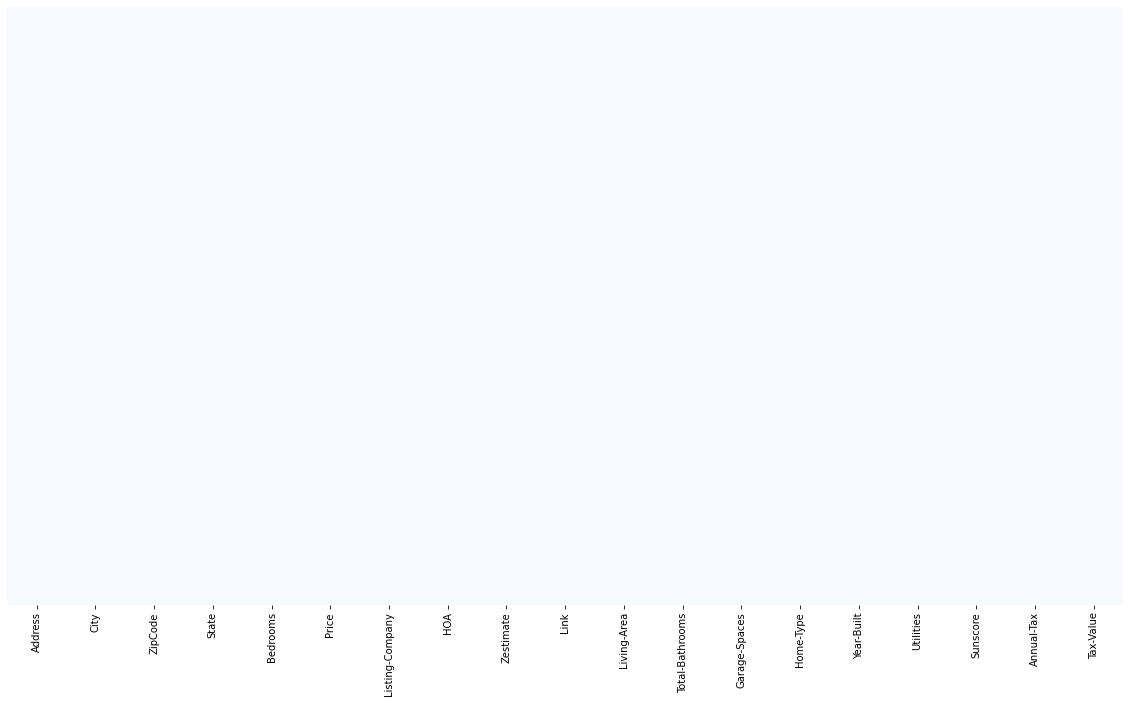

In [41]:
naInfo = np.zeros(z3.shape)
naInfo[z3.isna().values] = 1
naInfo = pd.DataFrame(naInfo, columns=z1.columns)
fig, ax = plt.subplots()
fig.set_size_inches(20, 11)
ax = sns.heatmap(naInfo, vmin=0, vmax=0.1, cmap='Blues', cbar=False)
ax.set_yticks([])

#no missing values

In [42]:
z3.to_csv("Zillow-CleanedData.csv") #export clean data to csv